# Placebo tests for excessive male mortality, excessive nuptiality and deposits

In [56]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression



In [4]:
df = pd.read_csv("data/deaths-by-age-gender-region-year-1990-2023.csv.gz")
df = df[df["Year"] <= 2019]

In [29]:
def get_excess(region):
    LinReg = LinearRegression()
    
    agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
                 '30-34 лет', '35-39 лет', '40-44 лет', 
                 '45-49 лет', '50-54 лет',  '55-59 лет']
    
    excess_male = [0, 0]          # For penultimate and last year
    total_baseline = [0, 0]
    excess_male_var = [0, 0]

    for age in agegroups:
        male = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'm') & 
            (df.Year >= 2013) & (df.Year <= 2019)
        ][['Year', 'Deaths']].values
        
        female = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'f') & 
            (df.Year >= 2013) & (df.Year <= 2019)
        ][['Year', 'Deaths']].values
        
        if len(male) < 7 or len(female) < 7:
            continue  # skip incomplete data
        
        ratio = male[:,1] / (1 + female[:,1])
        
        LinReg.fit(male[:5, 0].reshape(-1,1), ratio[:5].reshape(-1,1))
    
        for i, offset in enumerate([-2, -1]):  # second-last and last year
            ratio_hat = LinReg.predict(male[offset, 0].reshape(-1,1))[0][0]
            ratio_hat = max(ratio_hat, 1)
            yhat = (1 + female[offset, 1]) * ratio_hat
            excess_male[i] += male[offset, 1] - yhat
            total_baseline[i] += yhat

            # Compute predictive variance
            X = np.concatenate((male[:5,0].reshape(-1,1), np.ones((5,1))), axis=1)
            y = ratio[:5].reshape(-1,1)
            beta = np.linalg.pinv(X.T @ X) @ X.T @ y
            sigma2 = np.sum((y - X @ beta)**2) / (len(y) - 2)
            S = np.linalg.pinv(X.T @ X)
            x_new = np.array([[male[offset, 0], 1]])
            pred_var = sigma2 * (x_new @ S @ x_new.T + 1)
            excess_male_var[i] += pred_var[0][0] * (1 + female[offset,1])**2

    excess_pratio = [excess_male[i] / total_baseline[i] if total_baseline[i] > 0 else 0 for i in range(2)]
    z = [excess_male[i] / np.sqrt(excess_male_var[i]) if excess_male_var[i] > 0 else 0 for i in range(2)]
    
    return excess_male[0], excess_pratio[0], np.sqrt(excess_male_var[0]), z[0], \
           excess_male[1], excess_pratio[1], np.sqrt(excess_male_var[1]), z[1]


In [30]:
regions = df.Region.unique()

excess_regional = np.zeros((len(regions), 8)) 
for i, region in enumerate(regions):
    print('.', end='')
    excess_regional[i] = get_excess(region)


........................................................................................

In [31]:
good = ~np.isin(regions, ['Архангельская область', 'Тюменская область'])

df_both_years = pd.DataFrame({
    'Region': regions[good],
    'Excess 2018': excess_regional[:, 0][good],
    'Excess 2019': excess_regional[:, 2][good]
})

df_both_years = df_both_years[df_both_years['Region'] != 'Российская Федерация']
df_both_years

,Region,Excess 2018,Excess 2019
0,Алтайский край,55.429036,214.314196
1,Амурская область,-286.501338,111.569346
2,Архангельская область без АО,-160.699940,185.310099
3,Астраханская область,-340.760035,103.515324
4,Белгородская область,-112.581875,167.866831
...,...,...,...
81,Чувашская Республика,92.078853,193.962603
82,Чукотский АО,-58.190142,39.955612
83,Якутия,29.051224,121.924893
84,Ямало-Hенецкий АО,78.244047,82.614530


In [40]:
male_pop = pd.read_excel("data/male_pop.xls")
male_pop.columns.values[0:2] = ['age', 'Region']
male_pop['Region'] = male_pop['Region'].str.strip()
agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
             '30-34 лет', '35-39 лет', '40-44 лет', 
             '45-49 лет', '50-54 лет',  '55-59 лет']

male_pop_long = male_pop.melt(
    id_vars=['age', 'Region'],
    var_name='year',
    value_name='male_population'
)

male_pop_long['year'] = pd.to_numeric(male_pop_long['year'], errors='coerce')
male_pop_long = male_pop_long[male_pop_long['age'].isin(agegroups)]
male_pop_long = male_pop_long.dropna(subset=['male_population'])
male_pop_long = male_pop_long[male_pop_long['year'].isin([2018, 2019])]

male_pop1549 = male_pop_long.groupby(['Region', 'year'], as_index=False)['male_population'].sum()

region_name_mapping = {
    'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область без АО',
    'Ненецкий автономный округ (Архангельская область)': 'Ненецкий АО',
    'Кемеровская область - Кузбасс': 'Кемеровская область',
    'Город Москва столица Российской Федерации город федерального значения': 'Москва',
    'Город Санкт-Петербург город федерального значения': 'Санкт-Петербург',
    'Город федерального значения Севастополь': 'Севастополь',
    'Еврейская автономная область': 'Еврейская АО',
    'Кабардино-Балкарская Республика': 'Кабардино-Балкария',
    'Карачаево-Черкесская Республика': 'Карачаево-Черкесия',
    'Республика Адыгея (Адыгея)': 'Республика Адыгея',
    'Республика Саха (Якутия)': 'Якутия',
    'Республика Северная Осетия-Алания': 'Северная Осетия',
    'Республика Татарстан (Татарстан)': 'Республика Татарстан',
    'Чувашская Республика - Чувашия': 'Чувашская Республика',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область без АО',
    'Ханты-Мансийский автономный округ - Югра (Тюменская область)': 'Ханты-Мансийский АО',
    'Ямало-Ненецкий автономный округ (Тюменская область)': 'Ямало-Hенецкий АО',
    'Чукотский автономный округ': 'Чукотский АО',
}

male_pop1549['Region'] = male_pop1549['Region'].replace(region_name_mapping)

pop_pivot = male_pop1549.pivot(index='Region', columns='year', values='male_population').reset_index()
pop_pivot.columns.name = None  
pop_pivot = pop_pivot.rename(columns={
    2018: 'Male pop2018',
    2019: 'Male pop2019'
})

df_merged = df_both_years.merge(pop_pivot, on='Region', how='left')
df_merged['Excess per100k (2018)'] = df_merged['Excess 2018'] / df_merged['Male pop2018'] * 100_000
df_merged['Excess per100k (2019)'] = df_merged['Excess 2019'] / df_merged['Male pop2019'] * 100_000
df_merged["Excess total"] = df_merged["Excess per100k (2018)"] + df_merged["Excess per100k (2019)"]
df_merged

,Region,Excess 2018,Excess 2019,Male pop2018,Male pop2019,Excess per100k (2018),Excess per100k (2019),Excess total
0,Алтайский край,55.429036,214.314196,644582.0,627720.0,8.599222,34.141687,42.740909
1,Амурская область,-286.501338,111.569346,240589.0,237437.0,-119.083307,46.989031,-72.094276
2,Архангельская область без АО,-160.699940,185.310099,308814.0,299363.0,-52.037777,61.901470,9.863694
3,Астраханская область,-340.760035,103.515324,295961.0,291348.0,-115.136804,35.529787,-79.607016
4,Белгородская область,-112.581875,167.866831,457587.0,453146.0,-24.603381,37.044756,12.441375
...,...,...,...,...,...,...,...,...
80,Чувашская Республика,92.078853,193.962603,361953.0,354009.0,25.439450,54.790303,80.229753
81,Чукотский АО,-58.190142,39.955612,16702.0,16533.0,-348.402239,241.671880,-106.730359
82,Якутия,29.051224,121.924893,300551.0,300031.0,9.665988,40.637432,50.303420
83,Ямало-Hенецкий АО,78.244047,82.614530,176174.0,174107.0,44.412937,47.450435,91.863372


## Excessive Male Mortality 2018 vs 2019

In [41]:

fig = px.scatter(
    df_merged,
    x='Excess per100k (2018)',
    y='Excess per100k (2019)',
    hover_name='Region',
    title="Excess Male Mortality: 2018 vs 2019",
    labels={"Excess 2018": "Excess in 2018", "Excess 2019": "Excess in 2019"},
    width=800, height=700
)



fig.show()


## Placebo excessive Nuptiality September-November 2018

In [42]:
nup = pd.read_excel("data/data.xls", header=[0, 1])
nup = nup.drop(columns = nup.columns[0])
names = pd.read_excel("data/data.xls").iloc[1:,0]
nup.index = names
nup.index.name = "Region"
nup.columns = pd.MultiIndex.from_tuples(nup.columns)

nup_long = nup.stack(level=[0, 1]).reset_index()
nup_long.columns = ['Region', 'Year', 'Month', 'Marriages']
month_map = {
    'январь': 1, 'февраль': 2, 'март': 3, 'апрель': 4, 'май': 5, 'июнь': 6,
    'июль': 7, 'август': 8, 'сентябрь': 9, 'октябрь': 10, 'ноябрь': 11, 'декабрь': 12
}
nup_long['Month'] = nup_long['Month'].map(month_map)
nup_long['Year'] = nup_long['Year'].astype(int)

baseline = nup_long[nup_long['Year'].between(2013, 2017) & nup_long["Month"].between(9,11)]
expected = (
    baseline
    .groupby(['Region', 'Month'])['Marriages']
    .mean()
    .reset_index()
    .rename(columns={'Marriages': 'Expected'})
)

expected = expected.merge(nup_long[nup_long["Year"] == 2018], on = ['Region', 'Month'], how = 'left')
expected["Excess"] = expected["Marriages"] - expected["Expected"]

mar_ex = (
    expected
    .groupby(["Region"])["Excess"]
    .sum()
)
mar_ex.name = "Excessive Marriages"
mar_ex = mar_ex.reset_index()
mar_ex


C:\Users\aagal\AppData\Local\Temp\ipykernel_3568\993860574.py:8: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



,Region,Excessive Marriages
0,Архангельская область (кроме Ненец...,-653.5
1,Ненецкий автономный округ (Арханге...,-25.4
2,Тюменская область (кроме Ханты-Ман...,-1050.5
3,Ханты-Мансийский автономный округ ...,-1745.4
4,Ямало-Ненецкий автономный округ (Т...,-549.6
...,...,...
82,Челябинская область,-2958.8
83,Чеченская Республика,-368.6
84,Чувашская Республика - Чувашия,-537.6
85,Чукотский автономный округ,-6.8


In [43]:
region_name_mapping = {
    'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область без АО',
    'Ненецкий автономный округ (Архангельская область)': 'Ненецкий АО',
    'Кемеровская область - Кузбасс': 'Кемеровская область',
    'Город Москва столица Российской Федерации город федерального значения': 'Москва',
    'Город Санкт-Петербург город федерального значения': 'Санкт-Петербург',
    'Город федерального значения Севастополь': 'Севастополь',
    'Еврейская автономная область': 'Еврейская АО',
    'Кабардино-Балкарская Республика': 'Кабардино-Балкария',
    'Карачаево-Черкесская Республика': 'Карачаево-Черкесия',
    'Республика Адыгея (Адыгея)': 'Республика Адыгея',
    'Республика Саха (Якутия)': 'Якутия',
    'Республика Северная Осетия-Алания': 'Северная Осетия',
    'Республика Татарстан (Татарстан)': 'Республика Татарстан',
    'Чувашская Республика - Чувашия': 'Чувашская Республика',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область без АО',
    'Ханты-Мансийский автономный округ - Югра (Тюменская область)': 'Ханты-Мансийский АО',
    'Ямало-Ненецкий автономный округ (Тюменская область)': 'Ямало-Hенецкий АО',
    'Чукотский автономный округ': 'Чукотский АО',
}

mar_ex['Region'] = mar_ex['Region'].str.strip().replace(region_name_mapping)
df_full = df_merged.merge(mar_ex, on = "Region", how = "left")
df_full["Excessive Marriages per100k"] = df_full["Excessive Marriages"]/df_full["Male pop2018"]*100000
df_full


,Region,Excess 2018,Excess 2019,Male pop2018,Male pop2019,Excess per100k (2018),Excess per100k (2019),Excess total,Excessive Marriages,Excessive Marriages per100k
0,Алтайский край,55.429036,214.314196,644582.0,627720.0,8.599222,34.141687,42.740909,-1459.4,-226.410294
1,Амурская область,-286.501338,111.569346,240589.0,237437.0,-119.083307,46.989031,-72.094276,-327.8,-136.248956
2,Архангельская область без АО,-160.699940,185.310099,308814.0,299363.0,-52.037777,61.901470,9.863694,-653.5,-211.616054
3,Астраханская область,-340.760035,103.515324,295961.0,291348.0,-115.136804,35.529787,-79.607016,-935.6,-316.122732
4,Белгородская область,-112.581875,167.866831,457587.0,453146.0,-24.603381,37.044756,12.441375,-511.0,-111.672753
...,...,...,...,...,...,...,...,...,...,...
80,Чувашская Республика,92.078853,193.962603,361953.0,354009.0,25.439450,54.790303,80.229753,-537.6,-148.527571
81,Чукотский АО,-58.190142,39.955612,16702.0,16533.0,-348.402239,241.671880,-106.730359,-6.8,-40.713687
82,Якутия,29.051224,121.924893,300551.0,300031.0,9.665988,40.637432,50.303420,-551.4,-183.463040
83,Ямало-Hенецкий АО,78.244047,82.614530,176174.0,174107.0,44.412937,47.450435,91.863372,-549.6,-311.964308


## Excessive Mortality and Excessive Nuptiality

In [46]:
top10_x = df_full.nlargest(10, 'Excessive Marriages per100k')[['Region', 'Excessive Marriages per100k']]
top10_y = df_full.nlargest(10, 'Excess total')[['Region', 'Excess total']]
bottom10_x = df_full.nsmallest(10, 'Excessive Marriages per100k')[['Region', 'Excessive Marriages per100k']]
bottom10_y = df_full.nsmallest(10, 'Excess total')[['Region', 'Excess total']]

top10_x.reset_index(drop=True, inplace=True)
top10_y.reset_index(drop=True, inplace=True)
bottom10_x.reset_index(drop=True, inplace=True)
bottom10_y.reset_index(drop=True, inplace=True)

top10_x.columns = ['Top Nuptiality Region', 'Excessive Marriages per 100k']
top10_y.columns = ['Top Mortality Region', 'Excessive Male Mortality per100k']
bottom10_x.columns = ['Bottom Nuptiality Region', 'Excessive Marriages per 100k']
bottom10_y.columns = ['Bottom Mortality Region', 'Excessive Male Mortality per 100k']

combined = pd.concat([top10_x, top10_y, bottom10_x, bottom10_y], axis=1)
combined


,Top Nuptiality Region,Excessive Marriages per 100k,Top Mortality Region,Excessive Male Mortality per100k,Bottom Nuptiality Region,Excessive Marriages per 100k,Bottom Mortality Region,Excessive Male Mortality per 100k
0,Чукотский АО,-40.713687,Республика Алтай,188.346543,Новгородская область,-404.860213,Ненецкий АО,-151.515484
1,Республика Ингушетия,-45.174623,Мурманская область,182.897691,Севастополь,-385.696058,Чукотский АО,-106.730359
2,Чеченская Республика,-86.153501,Республика Тыва,138.813782,Санкт-Петербург,-374.179117,Астраханская область,-79.607016
3,Забайкальский край,-101.965444,Смоленская область,134.763767,Республика Крым,-359.648807,Амурская область,-72.094276
4,Республика Калмыкия,-108.888996,Брянская область,124.174048,Ханты-Мансийский АО,-322.967437,Пензенская область,-44.607451
5,Белгородская область,-111.672753,Республика Марий Эл,115.918421,Республика Хакасия,-322.138898,Магаданская область,-36.941454
6,Республика Татарстан,-114.382979,Новгородская область,113.512654,Магаданская область,-319.766828,Костромская область,-29.226441
7,Республика Тыва,-121.227060,Северная Осетия,106.219631,Костромская область,-317.582734,Приморский край,-27.308741
8,Северная Осетия,-135.219974,Забайкальский край,94.907285,Астраханская область,-316.122732,Сахалинская область,-25.551398
9,Амурская область,-136.248956,Ямало-Hенецкий АО,91.863372,Ямало-Hенецкий АО,-311.964308,Республика Калмыкия,-20.588377


In [47]:

fig = px.scatter(
    df_full,
    x='Excessive Marriages per100k',
    y='Excess total',
    hover_name='Region',
    title="Excessive Mortality and Excessive Nuptiality",
    labels={"Excessive Marriages per100k": "Excessive Nuptiality", "Excess total": "Excessive mortality"},
    width=800, height=700
)



fig.show()


## Including Deposits

In [49]:
dep = pd.read_excel("data/deposits.xlsx", header = 1)[:95]

dep["pmgrowth"] = (dep["01.10.2019"].astype(int)/dep["01.10.2018"].astype(int)-1)*100
dep = dep.rename(columns={dep.columns[0] : "Region"})

dep = dep[["Region", "pmgrowth"]]

region_name_mapping = {
    'Архангельская область без данных по Ненецкому автономному округу': 'Архангельская область без АО',
    'в том числе Ненецкий автономный округ': 'Ненецкий АО',
    'Кемеровская область - Кузбасс': 'Кемеровская область',
    'Город Москва столица Российской Федерации город федерального значения': 'Москва',
    'Город Санкт-Петербург город федерального значения': 'Санкт-Петербург',
    'Город федерального значения Севастополь': 'Севастополь',
    'Еврейская автономная область': 'Еврейская АО',
    'Кабардино-Балкарская Республика': 'Кабардино-Балкария',
    'Карачаево-Черкесская Республика': 'Карачаево-Черкесия',
    'Республика Адыгея (Адыгея)': 'Республика Адыгея',
    'Республика Саха (Якутия)': 'Якутия',
    'Республика Северная Осетия - Алания': 'Северная Осетия',
    'Республика Татарстан (Татарстан)': 'Республика Татарстан',
    'Чувашская Республика - Чувашия': 'Чувашская Республика',
    'Тюменская область без данных по Ханты-Мансийскому автономному округу - Югре и Ямало-Ненецкому автономному округу': 'Тюменская область без АО',
    'в том числе Ханты-Мансийский автономный округ - Югра': 'Ханты-Мансийский АО',
    'в том числе Ямало-Ненецкий автономный округ': 'Ямало-Hенецкий АО',
    'Чукотский автономный округ': 'Чукотский АО',
    'г. Москва' : 'Москва',
    'г. Санкт-Петербург' : 'Санкт-Петербург',
    'г. Севастополь' : 'Севастополь'
}

dep['Region'] = dep['Region'].replace(region_name_mapping)
df_full = df_full.merge(dep, on = "Region", how = "left")

df_full

,Region,Excess 2018,Excess 2019,Male pop2018,Male pop2019,Excess per100k (2018),Excess per100k (2019),Excess total,Excessive Marriages,Excessive Marriages per100k,pmgrowth
0,Алтайский край,55.429036,214.314196,644582.0,627720.0,8.599222,34.141687,42.740909,-1459.4,-226.410294,7.285206
1,Амурская область,-286.501338,111.569346,240589.0,237437.0,-119.083307,46.989031,-72.094276,-327.8,-136.248956,14.947093
2,Архангельская область без АО,-160.699940,185.310099,308814.0,299363.0,-52.037777,61.901470,9.863694,-653.5,-211.616054,7.950633
3,Астраханская область,-340.760035,103.515324,295961.0,291348.0,-115.136804,35.529787,-79.607016,-935.6,-316.122732,10.531008
4,Белгородская область,-112.581875,167.866831,457587.0,453146.0,-24.603381,37.044756,12.441375,-511.0,-111.672753,5.839476
...,...,...,...,...,...,...,...,...,...,...,...
80,Чувашская Республика,92.078853,193.962603,361953.0,354009.0,25.439450,54.790303,80.229753,-537.6,-148.527571,8.018333
81,Чукотский АО,-58.190142,39.955612,16702.0,16533.0,-348.402239,241.671880,-106.730359,-6.8,-40.713687,NaN
82,Якутия,29.051224,121.924893,300551.0,300031.0,9.665988,40.637432,50.303420,-551.4,-183.463040,7.291876
83,Ямало-Hенецкий АО,78.244047,82.614530,176174.0,174107.0,44.412937,47.450435,91.863372,-549.6,-311.964308,7.707700


### Deposits and Nuptiality

In [50]:
top10_x = df_full.nlargest(10, 'Excessive Marriages per100k')[['Region', 'Excessive Marriages per100k']]
top10_y = df_full.nlargest(10, 'pmgrowth')[['Region', 'pmgrowth']]
bottom10_x = df_full.nsmallest(10, 'Excessive Marriages per100k')[['Region', 'Excessive Marriages per100k']]
bottom10_y = df_full.nsmallest(10, 'pmgrowth')[['Region', 'pmgrowth']]

top10_x.reset_index(drop=True, inplace=True)
top10_y.reset_index(drop=True, inplace=True)
bottom10_x.reset_index(drop=True, inplace=True)
bottom10_y.reset_index(drop=True, inplace=True)

top10_x.columns = ['Top Nuptiality Region', 'Excessive Marriages per 100k']
top10_y.columns = ['Top Deposits growth', 'Deposits yoy growth in October 2023']
bottom10_x.columns = ['Bottom Nuptiality Region', 'Excessive Marriages per 100k']
bottom10_y.columns = ['Bottom Deposits growth', 'Deposits yoy growth in October 2023']

combined = pd.concat([top10_x, top10_y, bottom10_x, bottom10_y], axis=1)
combined


,Top Nuptiality Region,Excessive Marriages per 100k,Top Deposits growth,Deposits yoy growth in October 2023,Bottom Nuptiality Region,Excessive Marriages per 100k,Bottom Deposits growth,Deposits yoy growth in October 2023
0,Чукотский АО,-40.713687,Чеченская Республика,19.252447,Новгородская область,-404.860213,Тюменская область без АО,3.971132
1,Республика Ингушетия,-45.174623,Севастополь,16.533355,Севастополь,-385.696058,Республика Коми,4.970093
2,Чеченская Республика,-86.153501,Республика Дагестан,15.605667,Санкт-Петербург,-374.179117,Самарская область,5.214316
3,Забайкальский край,-101.965444,Республика Ингушетия,15.189536,Республика Крым,-359.648807,Ненецкий АО,5.690537
4,Республика Калмыкия,-108.888996,Амурская область,14.947093,Ханты-Мансийский АО,-322.967437,Белгородская область,5.839476
5,Белгородская область,-111.672753,Республика Крым,14.023302,Республика Хакасия,-322.138898,Карачаево-Черкесия,6.007265
6,Республика Татарстан,-114.382979,Республика Калмыкия,14.012119,Магаданская область,-319.766828,Хабаровский край,6.172955
7,Республика Тыва,-121.227060,Магаданская область,13.678470,Костромская область,-317.582734,Ульяновская область,6.431242
8,Северная Осетия,-135.219974,Вологодская область,13.156349,Астраханская область,-316.122732,Пермский край,6.466583
9,Амурская область,-136.248956,Иркутская область,12.344034,Ямало-Hенецкий АО,-311.964308,Кемеровская область,6.509780


In [52]:

fig = px.scatter(
    df_full,
    y='Excessive Marriages per100k',
    x='pmgrowth',
    hover_name='Region',
    title="Deposits growth in October 2019 (yoy) and Excessive Nuptiality",
    labels={"Excessive Marriages per100k": "Excessive Nuptiality", "pmgrowth": "Deposits growth"},
    width=800, height=700
)


fig.show()


### Deposits and Mortality


In [53]:
top10_x = df_full.nlargest(10, 'Excess total')[['Region', 'Excess total']]
top10_y = df_full.nlargest(10, 'pmgrowth')[['Region', 'pmgrowth']]
bottom10_x = df_full.nsmallest(10, 'Excess total')[['Region', 'Excess total']]
bottom10_y = df_full.nsmallest(10, 'pmgrowth')[['Region', 'pmgrowth']]

top10_x.reset_index(drop=True, inplace=True)
top10_y.reset_index(drop=True, inplace=True)
bottom10_x.reset_index(drop=True, inplace=True)
bottom10_y.reset_index(drop=True, inplace=True)

top10_x.columns = ['Top Mortality Region', 'Excessive Male Mortality']
top10_y.columns = ['Top Deposits growth', 'Deposits yoy growth in October 2023']
bottom10_x.columns = ['Bottom Mortality Region', 'Excessive Male Mortality']
bottom10_y.columns = ['Bottom Deposits growth', 'Deposits yoy growth in October 2023']

combined = pd.concat([top10_x, top10_y, bottom10_x, bottom10_y], axis=1)
combined


,Top Mortality Region,Excessive Male Mortality,Top Deposits growth,Deposits yoy growth in October 2023,Bottom Mortality Region,Excessive Male Mortality,Bottom Deposits growth,Deposits yoy growth in October 2023
0,Республика Алтай,188.346543,Чеченская Республика,19.252447,Ненецкий АО,-151.515484,Тюменская область без АО,3.971132
1,Мурманская область,182.897691,Севастополь,16.533355,Чукотский АО,-106.730359,Республика Коми,4.970093
2,Республика Тыва,138.813782,Республика Дагестан,15.605667,Астраханская область,-79.607016,Самарская область,5.214316
3,Смоленская область,134.763767,Республика Ингушетия,15.189536,Амурская область,-72.094276,Ненецкий АО,5.690537
4,Брянская область,124.174048,Амурская область,14.947093,Пензенская область,-44.607451,Белгородская область,5.839476
5,Республика Марий Эл,115.918421,Республика Крым,14.023302,Магаданская область,-36.941454,Карачаево-Черкесия,6.007265
6,Новгородская область,113.512654,Республика Калмыкия,14.012119,Костромская область,-29.226441,Хабаровский край,6.172955
7,Северная Осетия,106.219631,Магаданская область,13.678470,Приморский край,-27.308741,Ульяновская область,6.431242
8,Забайкальский край,94.907285,Вологодская область,13.156349,Сахалинская область,-25.551398,Пермский край,6.466583
9,Ямало-Hенецкий АО,91.863372,Иркутская область,12.344034,Республика Калмыкия,-20.588377,Кемеровская область,6.509780


In [54]:

fig = px.scatter(
    df_full,
    y='Excess total',
    x='pmgrowth',
    hover_name='Region',
    title="Deposits growth in October 2023 (yoy) and Excessive Mortality",
    labels={"pmgrowth": "Deposits Growth", "Excess total": "Excessive Mortality"},
    width=800, height=700
)


fig.show()


### Correlations

In [55]:
rename_map = {
    "pmgrowth": "Deposits Growth",
    "Excess total": "Excessive Male Mortality",
    "Excessive Marriages per100k": "Excessive Nuptiality"
}

df_selected = df_full[rename_map.keys()].rename(columns=rename_map)

cormat = df_selected.corr()


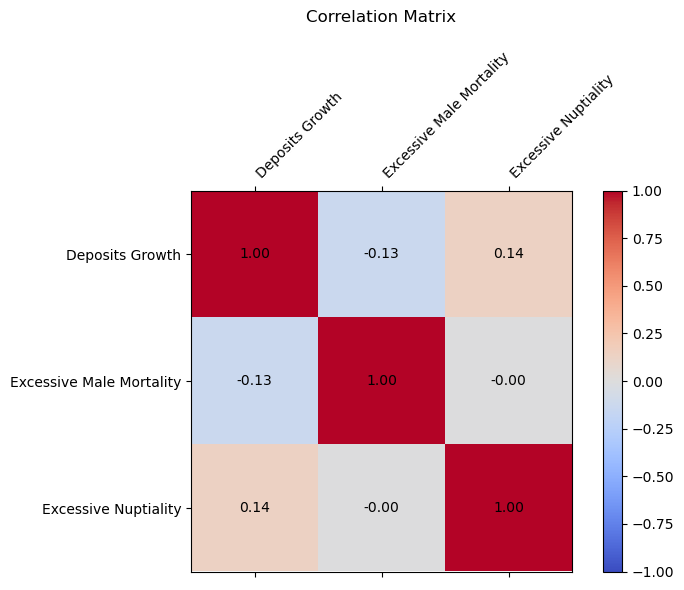

In [57]:
labels = df_selected.columns.tolist()
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(cormat, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='left')
ax.set_yticklabels(labels)

for (i, j), val in np.ndenumerate(cormat.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Matrix", pad=20)
plt.tight_layout()
plt.show()
